In [1]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

sys.path.append(parent_dir)

from simtrain import SETTINGS_POLIMI as SETTINGS
from simtrain.sim_models_new import Toy_intensity_Generator
import torch
import torch.optim as optim
import torch.nn as nn

import paths
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import simtrain.utils as utils
from tqdm import tqdm
import evotorch
import ray
from functools import partial

os.environ['PYTHONPATH'] = "/home/thahit/github/Recommender_Sim"
ray.init(ignore_reinit_error=True)


2024-08-06 18:16:18,700	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Python version:,3.9.19
Ray version:,2.9.0
Dashboard:,http://127.0.0.1:8265


In [2]:

state_size = SETTINGS.STATE_SIZE
experiment_name = "toy"
#num_negatives = 100
#conditioned=True
#kl_weight=.01

In [3]:
# parameter dicts
width= 8
user_state_dict = {"model_hyp": {"layer_width": [width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
gen_model = Toy_intensity_Generator(hyperparameter_dict)

In [4]:
path = join(paths.dat, SETTINGS.filepaths_new["simulate_intensity_model"]
            )
path

'/home/thahit/github/Recommender_Sim/dat/saved_models_polimi/simulate_intensity/gnerator_model.h5'

In [5]:
#torch.save(gen_model.state_dict(), path)
gen_model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [6]:
state = torch.zeros((1, state_size))

In [7]:
samples = [gen_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)
samples

array([[0. ],
       [1.1],
       [1.1],
       [0.4],
       [0.8],
       [0.8],
       [0.7],
       [0.1],
       [0.5],
       [0.1],
       [2.3],
       [0.7],
       [6.5],
       [3.7],
       [2.5],
       [0.6],
       [0.3],
       [1.2],
       [0.8],
       [1.4],
       [0.8],
       [1.5],
       [0.9],
       [0.4],
       [0.2],
       [1.4],
       [0.4],
       [0.9],
       [5.1],
       [0.2],
       [0.1],
       [5.6],
       [0.4],
       [1.9],
       [2.2],
       [1.2],
       [1.4],
       [2.7],
       [0.9],
       [0.5],
       [0. ],
       [0.1],
       [1.2],
       [3.1],
       [0.4],
       [0.6],
       [0.3],
       [1.9],
       [1.4],
       [0.1],
       [0.3],
       [0. ],
       [0.5],
       [0.1],
       [2. ],
       [3.4],
       [2.4],
       [0.7],
       [3.1],
       [1.1],
       [1.2],
       [0. ],
       [0.4],
       [3. ],
       [0. ],
       [0.4],
       [1.6],
       [0.8],
       [1.8],
       [4.9],
       [0.4],
      

feed in true values for fake models, 


/tmp/ipykernel_28416/2138906594.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)


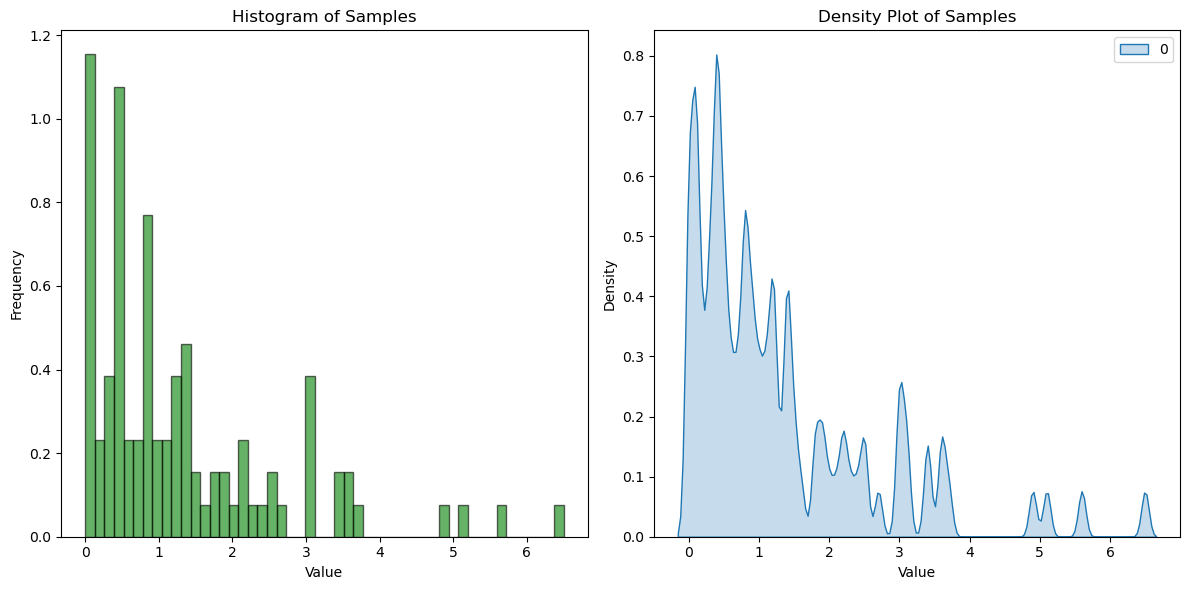

In [8]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


In [9]:
sample_path = gen_model.sample_path(num_samples=5)
sample_path =torch.tensor(sample_path)
sample_path

tensor([[1.3000],
        [2.2000],
        [3.8000],
        [3.8000],
        [5.8000]])

In [10]:
#load actual data instead
checkpoint = torch.load(join(paths.dat, SETTINGS.rootpaths['models'],
                             "testing", "data.h5"))
list_of_dicts = checkpoint['data']
chosen_sample = list_of_dicts[4]["timestamps"]
sample_path =torch.tensor(chosen_sample)
sample_path

tensor([ 5.0833,  6.3958, 11.8125, 28.0417, 28.2708, 40.1042, 42.8542])

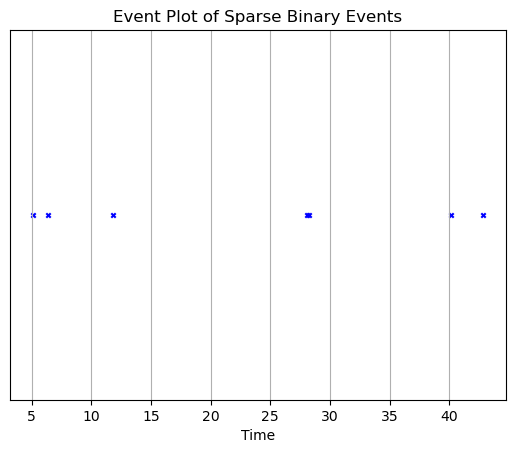

In [11]:
#plt.eventplot(sample_path, orientation='vertical', colors='r')
plt.scatter(sample_path, [1] * len(sample_path), color='blue', label='Time Series 1', s=10, marker='x')

plt.yticks([])
plt.xlabel('Time')
plt.title('Event Plot of Sparse Binary Events')
plt.grid(True)
plt.show()


## Train Gradient Descent
Not working

In [12]:
def train_single(model, path, scoring_func,optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                current_pred.append(last_t + model.sample_one(state))
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += torch.log(scoring_func(current_pred, timestep))
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
        print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()


In [13]:
# parameter dicts
width= 16
user_state_dict = {"model_hyp": {"layer_width": [width, width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width, width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [14]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [15]:
sample_path = torch.as_tensor(sample_path)
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)


In [16]:
#train_single(train_model, sample_path, scoring_func=utils.energy_score_loss,
#            optimizer=optimizer, num_epochs=30, num_tries=10)

### function approximation



In [17]:
from simtrain.sim_models_new import all_in_one_model

width=64
user_state_dict = {"model_hyp": {"layer_width": [width, width, width, width]}}
time_dict = {"model_hyp": {"layer_width": [width, width, width, 3]}
                            }

timecheat = False
hyperparameter_dict = {"state_size": state_size, "time_model": time_dict, 
                           "state_model": user_state_dict}
train_model = all_in_one_model(hyperparameter_dict, timecheat=timecheat)

In [18]:
def train_single_function_approx(model, path, scoring_func,optimizer, num_epochs=100, 
                                 num_tries=20, timecheat=False, loss_print_interval=1):
    
    for iter in tqdm(range(num_epochs)):
        last_t = 0
        state = torch.zeros((1, state_size))
        loss = 0.
        mse_loss = nn.MSELoss()
        #results = []
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time = model.get_time(state, timestep)
                else:
                    next_time = model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time)
            current_pred = torch.stack(current_pred)
            last_t = timestep
            #results.append(torch.mean(current_pred))
            timestep = torch.Tensor([[timestep]])
            #print(torch.mean(current_pred))
            #loss = loss + mse_loss(next_time, timestep)
            loss += torch.log(scoring_func(current_pred, timestep)+1e-25)# + thing should be useless

            state = model.get_new_state(state, timestep)
        if iter %loss_print_interval == 0:
            print("loss: ", loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()

        #for name, param in model.named_parameters():
        #    print(f"Parameter Name: {name}")
        #    print(f"Gradients: {param.grad}")
        #    print(f"Parameter Value: {param}")
        #    print(f"Parameter Shape: {param.shape}")
        #    print(f"Requires Gradient: {param.requires_grad}")
        #    print("-" * 40)
        #return
        optimizer.zero_grad()

        #return results
    print("loss: ", loss)
    

In [19]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.1,
                        weight_decay=1e-7)

In [20]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=100, num_tries=20, timecheat=timecheat, loss_print_interval=10)

  3%|▎         | 3/100 [00:00<00:03, 28.79it/s]

loss:  tensor(inf, grad_fn=<AddBackward0>)


 15%|█▌        | 15/100 [00:00<00:02, 31.73it/s]

loss:  tensor(11.9064, grad_fn=<AddBackward0>)


 23%|██▎       | 23/100 [00:00<00:02, 26.58it/s]

loss:  tensor(10.8562, grad_fn=<AddBackward0>)


 33%|███▎      | 33/100 [00:01<00:02, 23.69it/s]

loss:  tensor(8.4461, grad_fn=<AddBackward0>)


 48%|████▊     | 48/100 [00:01<00:01, 29.71it/s]

loss:  tensor(8.3163, grad_fn=<AddBackward0>)


 56%|█████▌    | 56/100 [00:02<00:01, 32.07it/s]

loss:  tensor(9.3694, grad_fn=<AddBackward0>)


 65%|██████▌   | 65/100 [00:02<00:01, 34.39it/s]

loss:  tensor(9.8276, grad_fn=<AddBackward0>)


 74%|███████▍  | 74/100 [00:02<00:00, 33.58it/s]

loss:  tensor(10.1651, grad_fn=<AddBackward0>)


 86%|████████▌ | 86/100 [00:02<00:00, 33.82it/s]

loss:  tensor(5.3567, grad_fn=<AddBackward0>)


 94%|█████████▍| 94/100 [00:03<00:00, 36.06it/s]

loss:  tensor(9.2311, grad_fn=<AddBackward0>)


100%|██████████| 100/100 [00:03<00:00, 30.52it/s]

loss:  tensor(10.1299, grad_fn=<AddBackward0>)


In [21]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.01,
                        weight_decay=1e-7)

In [22]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=200,timecheat=timecheat, num_tries=20, loss_print_interval=20)

  2%|▏         | 4/200 [00:00<00:05, 36.51it/s]

loss:  tensor(9.7532, grad_fn=<AddBackward0>)


 12%|█▏        | 23/200 [00:00<00:06, 29.43it/s]

loss:  tensor(8.6166, grad_fn=<AddBackward0>)


 22%|██▏       | 43/200 [00:01<00:05, 29.20it/s]

loss:  tensor(6.0277, grad_fn=<AddBackward0>)


 33%|███▎      | 66/200 [00:02<00:04, 29.13it/s]

loss:  tensor(7.6207, grad_fn=<AddBackward0>)


 42%|████▏     | 84/200 [00:02<00:04, 26.54it/s]

loss:  tensor(7.1194, grad_fn=<AddBackward0>)


 52%|█████▎    | 105/200 [00:03<00:04, 23.65it/s]

loss:  tensor(6.8691, grad_fn=<AddBackward0>)


 60%|██████    | 120/200 [00:04<00:03, 26.32it/s]


loss:  tensor(8.1548, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=300,timecheat=timecheat, num_tries=20, loss_print_interval=20)

  2%|▏         | 7/300 [00:00<00:08, 34.54it/s]

loss:  tensor(6.2634, grad_fn=<AddBackward0>)


  9%|▊         | 26/300 [00:00<00:09, 28.91it/s]

loss:  tensor(5.1327, grad_fn=<AddBackward0>)


 16%|█▌        | 48/300 [00:01<00:06, 37.00it/s]

loss:  tensor(2.0305, grad_fn=<AddBackward0>)


 23%|██▎       | 68/300 [00:01<00:05, 38.90it/s]

loss:  tensor(4.1795, grad_fn=<AddBackward0>)


 28%|██▊       | 84/300 [00:02<00:07, 29.63it/s]

loss:  tensor(4.4476, grad_fn=<AddBackward0>)


 35%|███▌      | 106/300 [00:03<00:06, 29.96it/s]

loss:  tensor(2.7681, grad_fn=<AddBackward0>)


 42%|████▏     | 126/300 [00:03<00:05, 30.91it/s]

loss:  tensor(4.1617, grad_fn=<AddBackward0>)


 48%|████▊     | 143/300 [00:04<00:04, 33.38it/s]

loss:  tensor(4.4476, grad_fn=<AddBackward0>)


 54%|█████▍    | 163/300 [00:04<00:03, 36.07it/s]

loss:  tensor(2.7535, grad_fn=<AddBackward0>)


 62%|██████▏   | 186/300 [00:05<00:03, 30.07it/s]

loss:  tensor(4.1653, grad_fn=<AddBackward0>)


 69%|██████▉   | 208/300 [00:06<00:02, 36.51it/s]

loss:  tensor(4.4476, grad_fn=<AddBackward0>)


 76%|███████▌  | 227/300 [00:06<00:01, 39.59it/s]

loss:  tensor(2.7387, grad_fn=<AddBackward0>)


 81%|████████▏ | 244/300 [00:07<00:01, 35.65it/s]

loss:  tensor(4.1653, grad_fn=<AddBackward0>)


 89%|████████▊ | 266/300 [00:07<00:00, 37.13it/s]

loss:  tensor(4.4503, grad_fn=<AddBackward0>)


 95%|█████████▍| 284/300 [00:08<00:00, 33.35it/s]

loss:  tensor(2.7387, grad_fn=<AddBackward0>)


100%|██████████| 300/300 [00:08<00:00, 33.42it/s]

loss:  tensor(4.3601, grad_fn=<AddBackward0>)


In [ ]:
optimizer = optim.AdamW(train_model.parameters(), lr=0.00001,
                        weight_decay=1e-7)

In [ ]:
train_single_function_approx(train_model, sample_path,scoring_func=utils.energy_score_loss,
            optimizer=optimizer, num_epochs=3000,timecheat=timecheat, num_tries=20, loss_print_interval=20)

  0%|          | 4/3000 [00:00<01:28, 33.95it/s]

loss:  tensor(4.1653, grad_fn=<AddBackward0>)


  1%|          | 25/3000 [00:00<01:27, 33.89it/s]

loss:  tensor(2.4853, grad_fn=<AddBackward0>)


  2%|▏         | 48/3000 [00:01<01:15, 39.29it/s]

loss:  tensor(0.8366, grad_fn=<AddBackward0>)


  2%|▏         | 67/3000 [00:01<01:12, 40.44it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


  3%|▎         | 84/3000 [00:02<01:31, 32.03it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


  4%|▎         | 107/3000 [00:03<01:29, 32.49it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


  4%|▍         | 124/3000 [00:03<01:30, 31.75it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


  5%|▍         | 144/3000 [00:04<01:21, 35.10it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


  6%|▌         | 166/3000 [00:04<01:22, 34.21it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


  6%|▌         | 187/3000 [00:05<01:23, 33.55it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


  7%|▋         | 203/3000 [00:06<01:31, 30.63it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


  7%|▋         | 224/3000 [00:06<01:33, 29.58it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


  8%|▊         | 241/3000 [00:07<01:32, 29.84it/s]

loss:  tensor(0.1435, grad_fn=<AddBackward0>)


  9%|▉         | 265/3000 [00:08<01:20, 33.97it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 10%|▉         | 285/3000 [00:08<01:28, 30.71it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 10%|█         | 304/3000 [00:09<01:25, 31.50it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 11%|█         | 324/3000 [00:10<01:18, 34.12it/s]

loss:  tensor(0.4799, grad_fn=<AddBackward0>)


 11%|█▏        | 344/3000 [00:10<01:21, 32.77it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 12%|█▏        | 367/3000 [00:11<01:09, 38.08it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 13%|█▎        | 383/3000 [00:11<01:18, 33.53it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 13%|█▎        | 404/3000 [00:12<01:18, 33.21it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 14%|█▍        | 427/3000 [00:13<01:09, 37.11it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 15%|█▍        | 443/3000 [00:13<01:20, 31.58it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 16%|█▌        | 468/3000 [00:14<01:15, 33.75it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 16%|█▌        | 484/3000 [00:14<01:20, 31.23it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 17%|█▋        | 504/3000 [00:15<01:12, 34.57it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 18%|█▊        | 527/3000 [00:16<01:03, 38.89it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 18%|█▊        | 548/3000 [00:16<01:09, 35.30it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 19%|█▉        | 566/3000 [00:17<01:09, 34.79it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 19%|█▉        | 584/3000 [00:17<01:08, 35.06it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 20%|██        | 604/3000 [00:18<01:14, 32.11it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 21%|██        | 626/3000 [00:18<01:05, 36.24it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 22%|██▏       | 647/3000 [00:19<01:03, 37.08it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 22%|██▏       | 667/3000 [00:20<01:04, 36.06it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 23%|██▎       | 687/3000 [00:20<01:01, 37.49it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 24%|██▎       | 708/3000 [00:21<01:01, 37.21it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 24%|██▍       | 724/3000 [00:21<01:22, 27.76it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 25%|██▍       | 744/3000 [00:22<01:08, 32.83it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 26%|██▌       | 765/3000 [00:23<01:05, 34.19it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 26%|██▌       | 785/3000 [00:23<01:09, 32.01it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 27%|██▋       | 804/3000 [00:24<00:56, 38.66it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 28%|██▊       | 825/3000 [00:24<01:00, 35.83it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 28%|██▊       | 847/3000 [00:25<00:55, 39.01it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 29%|██▉       | 864/3000 [00:25<01:02, 33.99it/s]

loss:  tensor(0.4799, grad_fn=<AddBackward0>)


 29%|██▉       | 883/3000 [00:26<01:21, 26.09it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 30%|███       | 902/3000 [00:27<01:09, 30.11it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 31%|███       | 924/3000 [00:28<01:09, 29.68it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 31%|███▏      | 944/3000 [00:28<01:05, 31.24it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 32%|███▏      | 966/3000 [00:29<01:00, 33.73it/s]

loss:  tensor(0.6135, grad_fn=<AddBackward0>)


 33%|███▎      | 986/3000 [00:29<01:00, 33.36it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 34%|███▎      | 1005/3000 [00:30<01:14, 26.66it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 34%|███▍      | 1025/3000 [00:31<01:11, 27.79it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 35%|███▍      | 1045/3000 [00:32<01:03, 30.57it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


 36%|███▌      | 1065/3000 [00:32<01:00, 32.08it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 36%|███▌      | 1085/3000 [00:33<00:56, 33.89it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 37%|███▋      | 1106/3000 [00:33<00:53, 35.48it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 37%|███▋      | 1124/3000 [00:34<00:52, 35.62it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 38%|███▊      | 1144/3000 [00:34<00:55, 33.45it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 39%|███▉      | 1165/3000 [00:35<00:54, 33.57it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 40%|███▉      | 1185/3000 [00:36<00:58, 30.84it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 40%|████      | 1207/3000 [00:36<00:57, 31.29it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 41%|████      | 1228/3000 [00:37<00:50, 34.81it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 41%|████▏     | 1244/3000 [00:38<00:54, 32.42it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 42%|████▏     | 1267/3000 [00:38<00:46, 37.19it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 43%|████▎     | 1284/3000 [00:39<00:48, 35.51it/s]

loss:  tensor(0.4799, grad_fn=<AddBackward0>)


 43%|████▎     | 1304/3000 [00:39<00:49, 34.39it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 44%|████▍     | 1325/3000 [00:40<00:46, 36.20it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 45%|████▍     | 1346/3000 [00:40<00:43, 37.73it/s]

loss:  tensor(0.1435, grad_fn=<AddBackward0>)


 45%|████▌     | 1363/3000 [00:41<00:51, 32.01it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


 46%|████▌     | 1383/3000 [00:42<00:48, 33.12it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 47%|████▋     | 1407/3000 [00:42<00:47, 33.54it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 47%|████▋     | 1423/3000 [00:43<00:50, 31.15it/s]

loss:  tensor(0.1435, grad_fn=<AddBackward0>)


 48%|████▊     | 1446/3000 [00:43<00:42, 36.71it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 49%|████▉     | 1468/3000 [00:44<00:41, 37.33it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 50%|████▉     | 1486/3000 [00:45<00:39, 37.95it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 50%|█████     | 1506/3000 [00:45<00:45, 33.11it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


 51%|█████     | 1527/3000 [00:46<00:41, 35.20it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 52%|█████▏    | 1545/3000 [00:46<00:39, 36.94it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 52%|█████▏    | 1565/3000 [00:47<00:41, 34.19it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 53%|█████▎    | 1585/3000 [00:47<00:42, 32.99it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 54%|█████▎    | 1605/3000 [00:48<00:39, 35.00it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 54%|█████▍    | 1627/3000 [00:49<00:37, 37.09it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 55%|█████▍    | 1647/3000 [00:49<00:41, 32.38it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 56%|█████▌    | 1667/3000 [00:50<00:39, 33.79it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 56%|█████▌    | 1684/3000 [00:50<00:43, 30.16it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 57%|█████▋    | 1708/3000 [00:51<00:33, 38.43it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 58%|█████▊    | 1728/3000 [00:52<00:32, 39.41it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 58%|█████▊    | 1744/3000 [00:52<00:34, 36.67it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 59%|█████▉    | 1764/3000 [00:53<00:36, 34.05it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


 59%|█████▉    | 1784/3000 [00:53<00:37, 32.67it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 60%|██████    | 1807/3000 [00:54<00:32, 36.34it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 61%|██████    | 1828/3000 [00:54<00:31, 37.56it/s]

loss:  tensor(-0.0797, grad_fn=<AddBackward0>)


 62%|██████▏   | 1845/3000 [00:55<00:29, 39.10it/s]

loss:  tensor(0.1435, grad_fn=<AddBackward0>)


 62%|██████▏   | 1865/3000 [00:55<00:30, 37.64it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 63%|██████▎   | 1886/3000 [00:56<00:31, 34.96it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 64%|██████▎   | 1907/3000 [00:56<00:29, 36.77it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 64%|██████▍   | 1926/3000 [00:57<00:27, 39.75it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 65%|██████▍   | 1947/3000 [00:58<00:31, 32.97it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 65%|██████▌   | 1964/3000 [00:58<00:28, 36.95it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 66%|██████▌   | 1985/3000 [00:59<00:28, 35.87it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 67%|██████▋   | 2005/3000 [00:59<00:24, 39.89it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 68%|██████▊   | 2025/3000 [01:00<00:26, 36.76it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 68%|██████▊   | 2045/3000 [01:00<00:27, 34.18it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 69%|██████▉   | 2065/3000 [01:01<00:31, 29.42it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 70%|██████▉   | 2086/3000 [01:02<00:26, 34.54it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 70%|███████   | 2105/3000 [01:02<00:33, 26.62it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 71%|███████   | 2121/3000 [01:03<00:28, 30.68it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 71%|███████▏  | 2144/3000 [01:04<00:34, 24.74it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 72%|███████▏  | 2165/3000 [01:05<00:28, 28.84it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 73%|███████▎  | 2186/3000 [01:05<00:23, 35.11it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 73%|███████▎  | 2203/3000 [01:06<00:21, 37.52it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 74%|███████▍  | 2228/3000 [01:06<00:22, 34.01it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 75%|███████▍  | 2244/3000 [01:07<00:25, 29.86it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 76%|███████▌  | 2266/3000 [01:08<00:25, 29.29it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 76%|███████▌  | 2284/3000 [01:08<00:25, 27.62it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 77%|███████▋  | 2305/3000 [01:09<00:21, 31.65it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 78%|███████▊  | 2325/3000 [01:10<00:22, 30.11it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 78%|███████▊  | 2345/3000 [01:10<00:19, 32.92it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 79%|███████▉  | 2365/3000 [01:11<00:19, 32.97it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 80%|███████▉  | 2385/3000 [01:12<00:19, 32.07it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 80%|████████  | 2405/3000 [01:12<00:17, 34.51it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 81%|████████  | 2426/3000 [01:13<00:15, 37.33it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 82%|████████▏ | 2446/3000 [01:13<00:15, 36.68it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 82%|████████▏ | 2467/3000 [01:14<00:14, 36.21it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 83%|████████▎ | 2487/3000 [01:15<00:15, 33.31it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 84%|████████▎ | 2508/3000 [01:15<00:13, 36.95it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 84%|████████▍ | 2524/3000 [01:16<00:14, 32.89it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 85%|████████▍ | 2546/3000 [01:16<00:15, 29.27it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 86%|████████▌ | 2565/3000 [01:17<00:16, 26.64it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 86%|████████▌ | 2583/3000 [01:18<00:14, 29.22it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 87%|████████▋ | 2603/3000 [01:18<00:14, 28.03it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 88%|████████▊ | 2627/3000 [01:19<00:11, 32.74it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 88%|████████▊ | 2647/3000 [01:20<00:10, 33.94it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 89%|████████▉ | 2668/3000 [01:21<00:08, 37.65it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 90%|████████▉ | 2685/3000 [01:21<00:08, 37.56it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 90%|█████████ | 2706/3000 [01:22<00:08, 34.88it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 91%|█████████ | 2726/3000 [01:22<00:07, 35.85it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 92%|█████████▏| 2747/3000 [01:23<00:07, 35.62it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 92%|█████████▏| 2767/3000 [01:23<00:06, 34.90it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 93%|█████████▎| 2785/3000 [01:24<00:07, 27.04it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 93%|█████████▎| 2803/3000 [01:25<00:06, 31.48it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 94%|█████████▍| 2823/3000 [01:25<00:06, 25.44it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 95%|█████████▍| 2845/3000 [01:26<00:05, 28.97it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 96%|█████████▌| 2868/3000 [01:27<00:03, 36.08it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


 96%|█████████▋| 2888/3000 [01:27<00:03, 36.55it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


 97%|█████████▋| 2904/3000 [01:28<00:02, 33.12it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 97%|█████████▋| 2924/3000 [01:29<00:02, 33.58it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


 98%|█████████▊| 2948/3000 [01:29<00:01, 35.58it/s]

loss:  tensor(-0.7728, grad_fn=<AddBackward0>)


 99%|█████████▉| 2964/3000 [01:30<00:00, 37.98it/s]

loss:  tensor(-1.4660, grad_fn=<AddBackward0>)


100%|█████████▉| 2985/3000 [01:31<00:00, 25.16it/s]

loss:  tensor(-0.3674, grad_fn=<AddBackward0>)


100%|██████████| 3000/3000 [01:31<00:00, 32.75it/s]

loss:  tensor(-45.1677, grad_fn=<AddBackward0>)


In [ ]:
adsfasdf

NameError: name 'adsfasdf' is not defined

## Train via Evolution

In [24]:
from evotorch.algorithms import PGPE, CMAES
from evotorch.logging import PandasLogger
from functools import partial


In [25]:
# parameter dicts
width= 64
user_state_dict = {"model_hyp": {"layer_width": [width,width, width]}}
intensity_state_dict = {"model_hyp": {"layer_width": [width, width,width],
                                                         "noise": 0}
                            }


hyperparameter_dict = {"state_size": state_size, "state_model": user_state_dict, 
                           "intensity_model": intensity_state_dict,# "num_recom" : num_items_per_recom,
                            "noise": 0.}
train_model = Toy_intensity_Generator(hyperparameter_dict)

In [ ]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(gen_model.state_dict(), path_train)
#train_model.load_state_dict(torch.load(path_train))

In [ ]:

def eval_single(model, path, scoring_func, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    loss = 0.
    #results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            #results.append(torch.mean(current_pred))
            loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return loss


eval_single_partial = partial(eval_single, path=sample_path, scoring_func=utils.energy_score_loss,
                              num_tries=30)

In [ ]:
eval_single_partial(train_model)

tensor(264.2917)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Single_path_problem = evotorch.neuroevolution.NEProblem(
    objective_sense="min",
    network= train_model,
    #network=Toy_intensity_Generator,
    #network_args = {"hyperparameter_dict": hyperparameter_dict},
    network_eval_func=eval_single_partial,
    device=device,
    num_actors = 20,
)

In [ ]:


searcher = PGPE(
    Single_path_problem,
    popsize=40,
    radius_init=5.,
    center_learning_rate=0.2,
    stdev_learning_rate=0.05,
)
'''
searcher = CMAES(
    Single_path_problem,
    popsize=20,  
    stdev_init= 2.
)'''

logger = PandasLogger(searcher)



In [ ]:
num_iterations = 20
for _ in tqdm(range(num_iterations), desc="Running PGPE"):
    searcher.step()

Running PGPE: 100%|██████████| 20/20 [05:07<00:00, 15.38s/it]


1 epoch = 50(population) * 20(samples for expectation) * 1(number of paths) * 10'000(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 300m NN calls per epoch

for much worse approximation and still way too much compute:<br>
1 epoch = 20(population) * 20(samples for expectation) * 1(number of paths) * 100(integration/for loop steps, worst case) * (2+1) (neural network calls) *10(number of events)= 1.2m NN calls per epoch


lstm/rnn  feed last hidden state + actual state to predict probability increase,  stop at  threshhold chosen by uniform 


neural network(time? + state)  -> time + state

noise for time but not state

normalizing flows?

<Axes: xlabel='iter'>

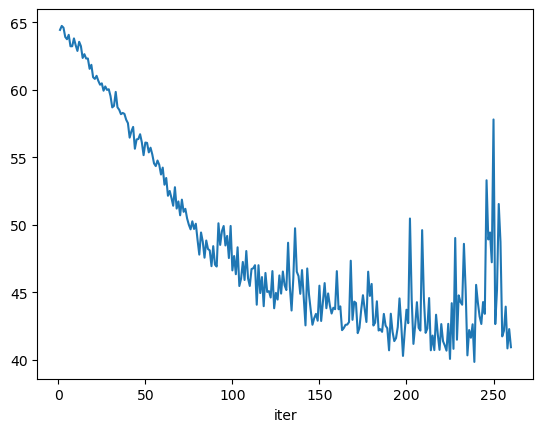

In [ ]:
logger.to_dataframe().mean_eval.plot()# test datapoint CMA ES

In [ ]:
asdcas

In [ ]:
trained_network = Single_path_problem.parameterize_net(searcher.status["center"])


In [27]:
path_train = join(paths.dat, SETTINGS.filepaths_new["copy_intensity_model"]
            )
#torch.save(trained_network.state_dict(), path_train)
train_model.load_state_dict(torch.load(path_train))
trained_network = train_model

# Visualize

In [ ]:
trained_network = train_model

In [28]:

def simulate_single_forced(model, path, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            print(f"var(forced): {torch.var(current_pred)}")
            #loss += scoring_func(current_pred, timestep)
            delta = timestep-last_t
            last_t = timestep
            state = model.evolve_state(state, delta)
    
    return results

def simulate_single_forced_function_approx(model, path, 
                                           timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, timestep)
                else:
                    next_time=model.get_time(state)
                #print(f"next_time: {next_time}, next_state: {next_state}")
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            results.append(torch.mean(current_pred))
            last_t = timestep
            state = model.get_new_state(state, torch.tensor([[timestep]]))
    
    return results

def simulate_single_function_approx(model, path, timecheat=False, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for timestep in path:
            current_pred = []
            for _ in range(num_tries):
                if timecheat:
                    next_time=model.get_time(state, timestep)
                else:
                    next_time=model.get_time(state)
                
                current_pred.append(last_t + next_time[0])
            current_pred = torch.stack(current_pred)
            selected = torch.mean(current_pred)
            results.append(selected)
            last_t = selected
            state = model.get_new_state(state, torch.tensor([[selected]]))
    
    return results

def simulate_single(model, num_events, num_tries=20):
    
    last_t = 0
    state = torch.zeros((1, state_size))
    results = []
    with torch.no_grad():
        for i in range(num_events):
            current_pred = []
            for _ in range(num_tries):
                out = model.sample_one(state)
                current_pred.append(last_t + out)
            current_pred = torch.stack(current_pred)
            print(f"var: {torch.var(current_pred)}")
            selected = torch.mean(current_pred)
            results.append(selected)
            delta = selected-last_t
            last_t = selected
            state = model.evolve_state(state, delta)
    
    return results


In [29]:
# simpler nn
simulate_single_partial_forced_function_approx = partial(
    simulate_single_forced_function_approx, path=sample_path,
                              num_tries=30, timecheat=timecheat)
simulate_single_partial_function_approx =partial(
    simulate_single_function_approx, path=sample_path,
                              num_tries=30, timecheat=timecheat)

In [30]:
# integrals
simulate_single_partial_forced = partial(simulate_single_forced, path=sample_path, 
                              num_tries=2)

simulate_single_partial = partial(simulate_single, num_events=12,
                              num_tries=2)


In [31]:
example_out_forced = simulate_single_partial_forced(trained_network)
example_out = simulate_single_partial(trained_network)

var(forced): 12.004998207092285
var(forced): 0.40500009059906006
var(forced): 1.4449996948242188
var(forced): 23.1200008392334
var(forced): 5.445003986358643
var(forced): 0.17999908328056335
var(forced): 0.0200001522898674
var: 1.9999998807907104
var: 8.820001602172852
var: 14.044998168945312
var: 1.6200003623962402
var: 0.0200001522898674
var: 21.12501335144043
var: 3.6449968814849854
var: 57.24498748779297
var: 144.50003051757812
var: 0.9799968004226685
var: 1.2799975872039795
var: 2.0


In [ ]:
#mlp
example_out_forced = simulate_single_partial_forced_function_approx(trained_network)
example_out = simulate_single_partial_function_approx(trained_network)

AttributeError: 'Toy_intensity_Generator' object has no attribute 'get_time'

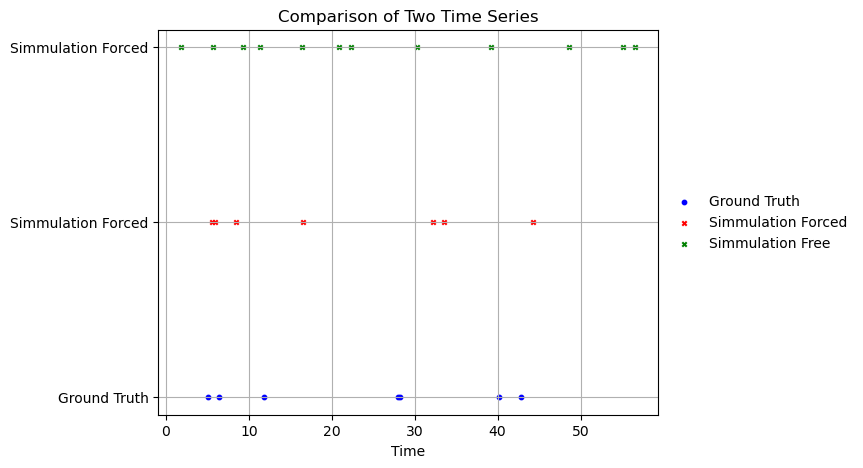

In [32]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Forced"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
asdfasf

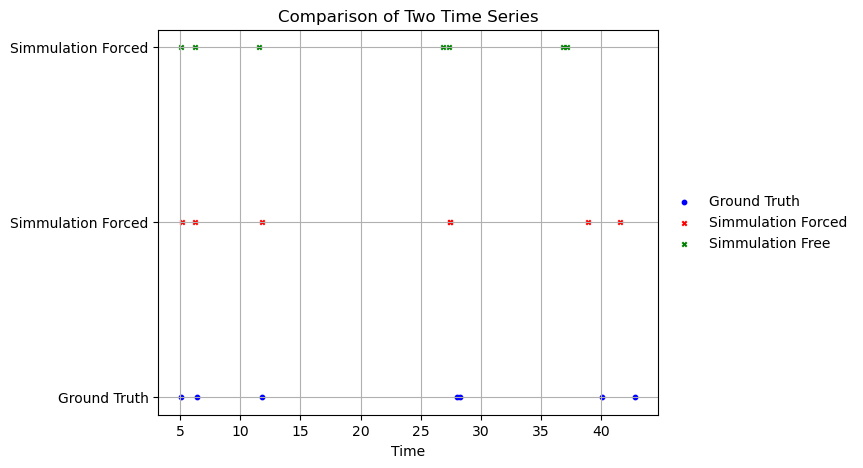

In [ ]:
# 3 layers
import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Forced"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
SCA

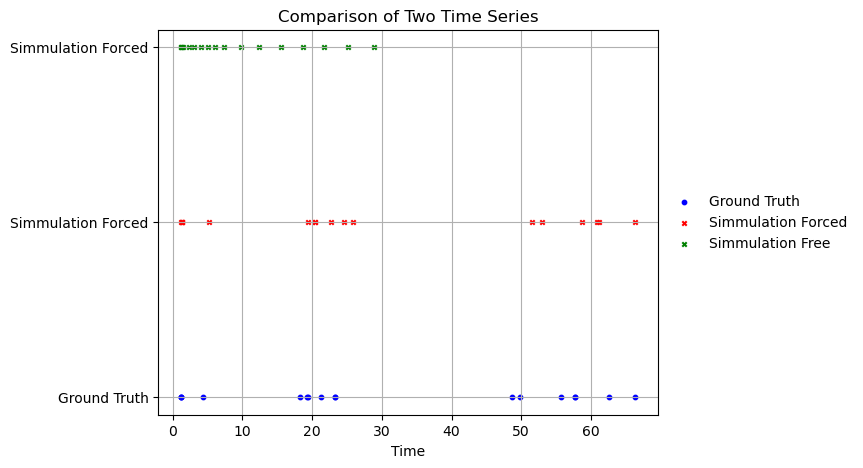

In [ ]:

import matplotlib.pyplot as plt

# Example data: replace these with your actual time series data
time_series_1 = sample_path # Timestamps for the first time series
time_series_2 = torch.clamp(torch.as_tensor(example_out_forced),0,70).detach().numpy()  # Timestamps for the second time series
time_series_3 = torch.clamp(torch.as_tensor(example_out), 0, 70).detach().numpy()  # Timestamps for the second time series


# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the first time series
ax.scatter(time_series_1, [1] * len(time_series_1), color='blue', label='Ground Truth', s=10, marker='o')

# Plot the second time series
ax.scatter(time_series_2, [2] * len(time_series_2), color='red', label='Simmulation Forced', s=10, marker='x')

ax.scatter(time_series_3, [3] * len(time_series_3), color='green', label='Simmulation Free', s=10, marker='x')


# Add labels, legend, and grid
ax.set_xlabel('Time')
ax.set_yticks([1, 2, 3])
ax.set_yticklabels(['Ground Truth', 'Simmulation Forced', "Simmulation Forced"])
ax.set_title('Comparison of Two Time Series')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust subplot parameters to make room for the legend
plt.subplots_adjust(right=0.75)
ax.grid(True)

# Display the plot
plt.show()


In [ ]:
scsdc

NameError: name 'scsdc' is not defined

In [33]:
state = torch.zeros((1, state_size))
samples = [train_model.sample_one(state).detach().numpy() for _ in range(100)]
samples = np.array(samples)

/tmp/ipykernel_28416/2138906594.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)


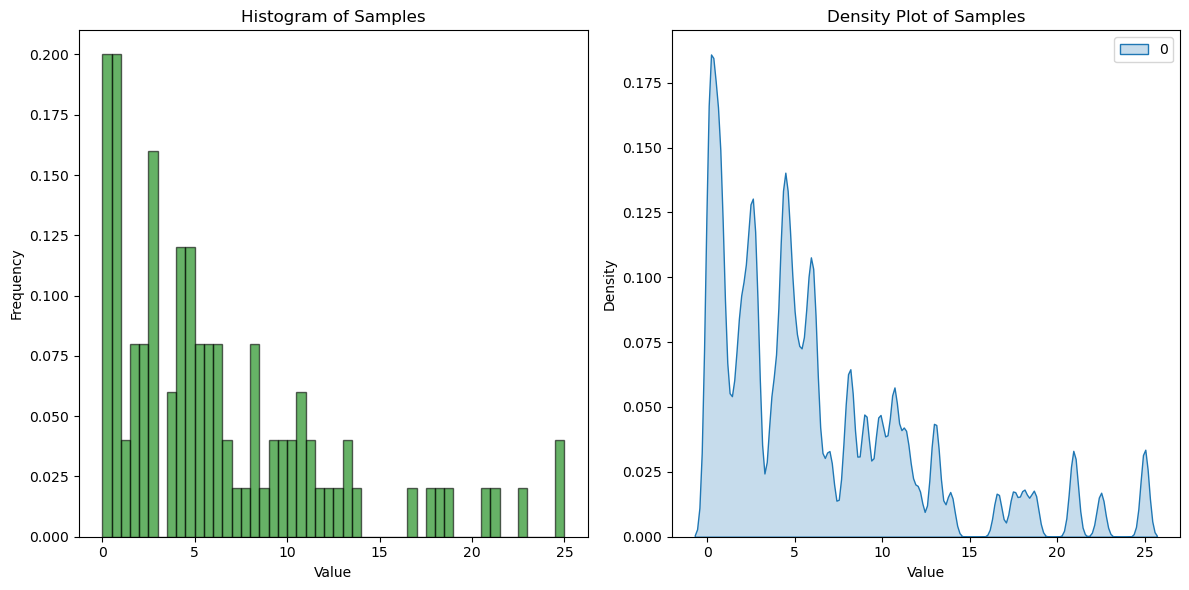

In [35]:
plt.figure(figsize=(12, 6))

# Histogram
plt.subplot(1, 2, 1)
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g', edgecolor='black')
plt.title('Histogram of Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Density Plot
plt.subplot(1, 2, 2)
sns.kdeplot(samples, shade=True, color='g', bw_adjust=0.1)
plt.title('Density Plot of Samples')
plt.xlabel('Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


# Multiple paths

## Gradient descent

In [ ]:
sample_paths = [torch.as_tensor(gen_model.sample_path(num_samples=7 + i%10)) for i in range(100)]

u: tensor([0.8357]) 	 h: tensor([[0.2700]])
u: tensor([0.8101]) 	 h: tensor([[0.3100]])
u: tensor([0.2139]) 	 h: tensor([[2.2300]])
u: tensor([0.1892]) 	 h: tensor([[2.2800]])
u: tensor([0.1829]) 	 h: tensor([[2.1500]])
u: tensor([0.4126]) 	 h: tensor([[1.0600]])
u: tensor([0.3895]) 	 h: tensor([[1.0800]])
u: tensor([0.4360]) 	 h: tensor([[1.2200]])
u: tensor([0.1618]) 	 h: tensor([[2.5900]])
u: tensor([0.8804]) 	 h: tensor([[0.1800]])
u: tensor([0.6596]) 	 h: tensor([[0.5700]])
u: tensor([0.6600]) 	 h: tensor([[0.5600]])
u: tensor([0.5202]) 	 h: tensor([[0.8500]])
u: tensor([0.7351]) 	 h: tensor([[0.3900]])
u: tensor([0.6919]) 	 h: tensor([[0.4600]])
u: tensor([0.3750]) 	 h: tensor([[1.4300]])
u: tensor([0.3858]) 	 h: tensor([[1.3700]])
u: tensor([0.7856]) 	 h: tensor([[0.3400]])
u: tensor([0.2851]) 	 h: tensor([[1.7200]])
u: tensor([0.9356]) 	 h: tensor([[0.0900]])
u: tensor([0.3759]) 	 h: tensor([[1.2700]])
u: tensor([0.5827]) 	 h: tensor([[0.6800]])
u: tensor([0.5802]) 	 h: tensor(

In [ ]:
from tqdm import tqdm
def train(model, paths, scoring_func, optimizer, num_epochs=100, num_tries=20):
    
    for iter in tqdm(range(num_epochs)):
        avg_loss = 0
        #results = []
        for path in paths:
            last_t = 0
            state = torch.zeros((1, state_size))
            loss = 0.
            for timestep in path:
                current_pred = []
                for _ in range(num_tries):
                    current_pred.append(last_t + model.sample_one(state))
                current_pred = torch.stack(current_pred)
                #results.append(torch.mean(current_pred))
                loss += scoring_func(current_pred, timestep)
                delta = timestep-last_t
                last_t = timestep
                state = model.evolve_state(state, delta)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2)
            optimizer.step()
            optimizer.zero_grad()
            avg_loss += loss
        print("loss: ", loss)
        

In [ ]:
results = train(train_model, sample_paths, scoring_func=utils.energy_score_loss,
                optimizer=optimizer, num_epochs=30, num_tries=20)

  0%|          | 0/30 [00:00<?, ?it/s]

u: tensor([0.3485]) 	 h: tensor([[0.4800]], grad_fn=<AddBackward0>)
u: tensor([0.7311]) 	 h: tensor([[0.1300]], grad_fn=<AddBackward0>)
u: tensor([0.7004]) 	 h: tensor([[0.1500]], grad_fn=<AddBackward0>)
u: tensor([0.1868]) 	 h: tensor([[19.8404]], grad_fn=<AddBackward0>)
u: tensor([0.9484]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.0248]) 	 h: tensor([[20.0004]], grad_fn=<AddBackward0>)
u: tensor([0.9544]) 	 h: tensor([[0.0200]], grad_fn=<AddBackward0>)
u: tensor([0.2849]) 	 h: tensor([[2.0900]], grad_fn=<AddBackward0>)
u: tensor([0.4395]) 	 h: tensor([[0.3600]], grad_fn=<AddBackward0>)
u: tensor([0.3872]) 	 h: tensor([[0.4200]], grad_fn=<AddBackward0>)
u: tensor([0.9265]) 	 h: tensor([[0.0300]], grad_fn=<AddBackward0>)
u: tensor([0.2972]) 	 h: tensor([[0.6700]], grad_fn=<AddBackward0>)
u: tensor([0.8400]) 	 h: tensor([[0.0700]], grad_fn=<AddBackward0>)
u: tensor([0.5358]) 	 h: tensor([[0.2700]], grad_fn=<AddBackward0>)
u: tensor([0.3007]) 	 h: tensor([[0.6500]], gr

  0%|          | 0/30 [00:34<?, ?it/s]

u: tensor([0.6625]) 	 h: tensor([[16.4203]], grad_fn=<AddBackward0>)


KeyboardInterrupt: 